# Vegetable Image Classification
### Using MobileNetV2 & Weights & Biases

This notebook implements an end-to-end **computer vision pipeline** for classifying
15 types of vegetables using **transfer learning (MobileNetV2)**.

**Pipeline Overview**
1. Data Collection
2. Data Exploration & Visualization
3. Data Splitting
4. Data Preprocessing
5. Data Augmentation
6. Model Building
7. Training
8. Evaluation
9. Model Saving
10. Inference (Deployment Ready)


## Environment Setup & Library Imports

In this section, we import all required libraries for data handling, visualization,
model training, and evaluation.


In [2]:
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Experiment Tracking
import wandb
from wandb.integration.keras import WandbCallback


## Global Configuration


In [3]:
IMG_SIZE = (224, 224)
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 3e-4
SEED = 42

DATASET_DIR = "dataset"  # adjust if needed


## Initialize Weights & Biases
W&B is used to track experiments, metrics, and hyperparameters.


In [4]:
wandb.init(
    project="Vegetable-Reco",
    name="mobilenetv2-baseline",
    tags=["mobilenetv2", "transfer-learning", "image-classification"],
    config={
        "architecture": "MobileNetV2",
        "image_size": IMG_HEIGHT,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "optimizer": "Adam",
        "augmentation": True,
        "num_classes": 15,
        "dataset": "Vegetable Image Dataset"
    }
)


wandb: Currently logged in as: m1nees. Use `wandb login --relogin` to force relogin


## Data Exploration & Visualization
We analyze class distribution to ensure the dataset is balanced.


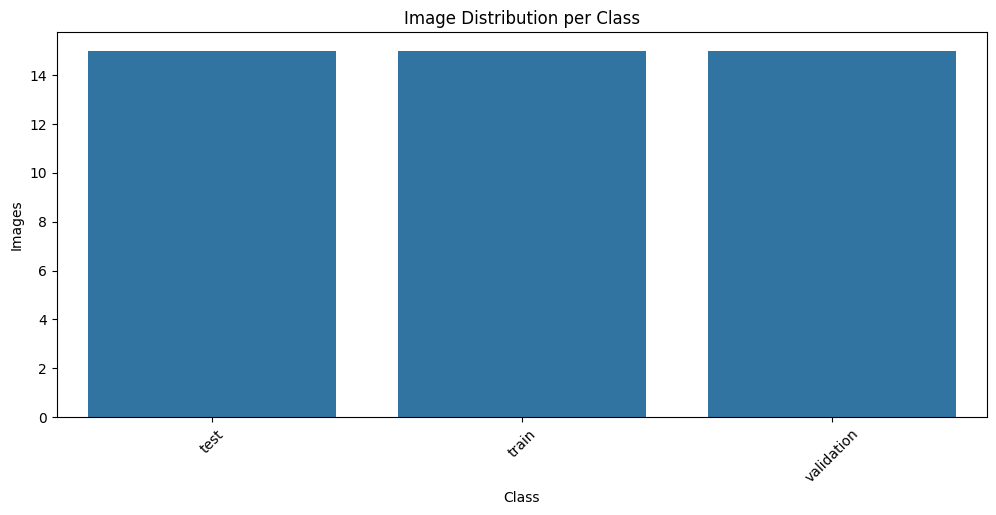

In [5]:
class_names = sorted(os.listdir(DATASET_DIR))
num_classes = len(class_names)

image_counts = []
for cls in class_names:
    image_counts.append(len(os.listdir(os.path.join(DATASET_DIR, cls))))

df = pd.DataFrame({
    "Class": class_names,
    "Images": image_counts
})

plt.figure(figsize=(12,5))
sns.barplot(data=df, x="Class", y="Images")
plt.xticks(rotation=45)
plt.title("Image Distribution per Class")
plt.show()


## 5. Dataset Loading & Splitting
Train: 70%  
Validation: 15%  
Test: 15%


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = val_test_ds.take(int(0.5 * len(val_test_ds)))
test_ds = val_test_ds.skip(int(0.5 * len(val_test_ds)))


Found 21000 files belonging to 3 classes.
Using 14700 files for training.
Found 21000 files belonging to 3 classes.
Using 6300 files for validation.


## Data Preprocessing & Augmentation
To improve generalization, data augmentation is applied only to training data.


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (preprocess_input(data_augmentation(x)), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)


## Model Building (MobileNetV2)
Transfer learning is used with ImageNet pre-trained weights.


In [11]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(15, activation="softmax")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

## Model Training
Training includes early stopping and learning rate scheduling.


In [ ]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        WandbCallback(save_model=False),
        early_stopping,
        reduce_lr
    ]
)

Epoch 1/30
